In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt 
import seaborn as sns
import osmnx as ox
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import folium
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

In [8]:
df = pd.read_csv('data_start.csv')

In [27]:
import pandas as pd

# Beispiel-DataFrame
# df = pd.read_your_data_source()

# 1. Datenvorbereitung: Auswahl der relevanten Spalten
relevant_columns = ['start_station_id', 'cluster']

# 2. Häufigkeitsanalyse
# Zählen Sie, wie oft jede Station in jedem Cluster als Start- oder Endstation auftritt
station_counts = df[relevant_columns].melt(id_vars=['cluster'], value_name='station').groupby(['cluster', 'station']).size().reset_index(name='count')

# Sortieren der Daten für Pareto-Analyse
station_counts = station_counts.sort_values(['cluster', 'count'], ascending=[True, False])

# 3. Pareto-Analyse: Ermittlung der kumulativen Prozentzahl und Auswahl der wichtigsten Stationen pro Cluster
station_counts['cumulative_percentage'] = station_counts.groupby('cluster')['count'].apply(lambda x: x.cumsum() / x.sum() * 100)

# Identifizierung der wichtigsten Stationen (z.B. top 20%)
threshold = 20
important_stations = station_counts[station_counts.groupby('cluster')['cumulative_percentage'].apply(lambda x: x <= threshold)]

print(important_stations)


     cluster       station  count  cumulative_percentage
98         0        WL-012  21208               3.064408
4          0         13016  20311               5.999205
1          0         13001  19673               8.841816
24         0         13430  19155              11.609580
3          0         13011  18879              14.337463
74         0  TA1305000011  18365              16.991078
90         0  TA1307000151  18149              19.613481
109        1         15544  22246              12.811638
226        2         13022  64538               3.171983
279        2         13300  36139               4.948182
229        2         13042  35001               6.668449
361        2        LF-005  35001               8.388716
422        2  TA1308000050  29769               9.851835
412        2  TA1308000001  29305              11.292149
225        2         13008  28967              12.715850
386        2  TA1307000039  27358              14.060471
250        2         13146  231

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/3645431079.py:17: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  station_counts['cumulative_percentage'] = station_counts.groupby('cluster')['count'].apply(lambda x: x.cumsum() / x.sum() * 100)
/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/3645431079.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt

In [28]:
important_stations

,cluster,station,count,cumulative_percentage
98,0,WL-012,21208,3.064408
4,0,13016,20311,5.999205
1,0,13001,19673,8.841816
24,0,13430,19155,11.609580
3,0,13011,18879,14.337463
74,0,TA1305000011,18365,16.991078
90,0,TA1307000151,18149,19.613481
109,1,15544,22246,12.811638
226,2,13022,64538,3.171983
279,2,13300,36139,4.948182


In [17]:

# Daten vorbereiten
df = df.copy()
df['started_at'] = pd.to_datetime(df['started_at'])
df['hour'] = df['started_at'].dt.hour
df['weekday'] = df['started_at'].dt.dayofweek

# Vorhersagen für jede Station
station_forecasts = {}
for station_id in df['start_station_id'].unique():
    station_data = df[df['start_station_id'] == station_id]

    # Aggregation der Daten auf Wochenbasis
    weekly_data = station_data.resample('W', on='started_at').count()['ride_id']

    # Überprüfung, ob genügend Datenpunkte vorhanden sind
    if len(weekly_data) < 10:  # Beispiel: Mindestanzahl an Datenpunkten festlegen
        print(f"Nicht genügend Daten für Station {station_id}, überspringe...")
        continue

    # Fortsetzung mit dem ARIMA-Modell, wenn genügend Daten vorhanden sind
    model = auto_arima(weekly_data, seasonal=True, m=4, trace=True,
                       error_action='ignore', suppress_warnings=True, stepwise=True)
    ...

    # Vorhersage für die nächsten 4 Wochen
    forecast = model.predict(n_periods=4)

    # Verwende den durchschnittlichen Vorhersagewert der nächsten 4 Wochen
    adjusted_forecast = forecast.mean()

    station_forecasts[station_id] = adjusted_forecast

# Angenommen, `demand_patterns` ist bereits für jedes Cluster berechnet
detailed_forecasts = {}
for station_id, weekly_total_forecast in station_forecasts.items():
    cluster_id = df[df['start_station_id'] == station_id]['cluster'].iloc[0]
    demand_pattern = demand_patterns[cluster_id]

    detailed_station_forecast = {}
    for (weekday, hour), proportion in demand_pattern.items():
        forecast_value = weekly_total_forecast * proportion
        detailed_station_forecast[(weekday, hour)] = round(forecast_value)

    detailed_forecasts[station_id] = detailed_station_forecast


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=636.102, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=635.580, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=635.067, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=634.177, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=633.612, Time=0.03 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=635.381, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=633.079, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=634.262, Time=0.11 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=635.066, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[4]             : AIC=631.179, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[4]             : AIC=inf, Time=0.04 sec
 A

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialisierung von Listen, um alle tatsächlichen und prognostizierten Werte zu speichern
all_actuals = []
all_forecasts = []

# Iteriere durch jede Station, um die gesamten tatsächlichen und prognostizierten Werte zu sammeln
for station_id in df['start_station_id'].unique():
    # Extrahieren der tatsächlichen Daten für die spezifizierte Zeitperiode
    actual_data = df[(df['start_station_id'] == station_id) & 
                     (df['started_at'] >= '2022-05-23') & 
                     (df['started_at'] < '2022-05-30')]

    # Aggregieren der tatsächlichen Daten nach Stunde
    actual_data['hour'] = actual_data['started_at'].dt.floor('H')
    actual_rides = actual_data.groupby('hour').size()

    # Extrahieren der prognostizierten Daten
    forecast_data = detailed_forecasts.get(station_id, {})
    forecast_values = [forecast_data.get((pd.to_datetime(d).weekday(), pd.to_datetime(d).hour), 0) for d in actual_data['started_at'].dt.floor('H').unique()]

    # Stelle sicher, dass die Längen von tatsächlichen und prognostizierten Daten übereinstimmen, um sie zu aggregieren
    if len(actual_rides) == len(forecast_values):
        all_actuals.extend(actual_rides)
        all_forecasts.extend(forecast_values)

# Berechnung von MAE und RMSE
mae = mean_absolute_error(all_actuals, all_forecasts)
rmse = np.sqrt(mean_squared_error(all_actuals, all_forecasts))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/772198767.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')
/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/772198767.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')
/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/772198767.py:16: SettingWithCopyWarning: 
A value is trying to be s

MAE: 2.2406790193198507
RMSE: 4.37738910992918


/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


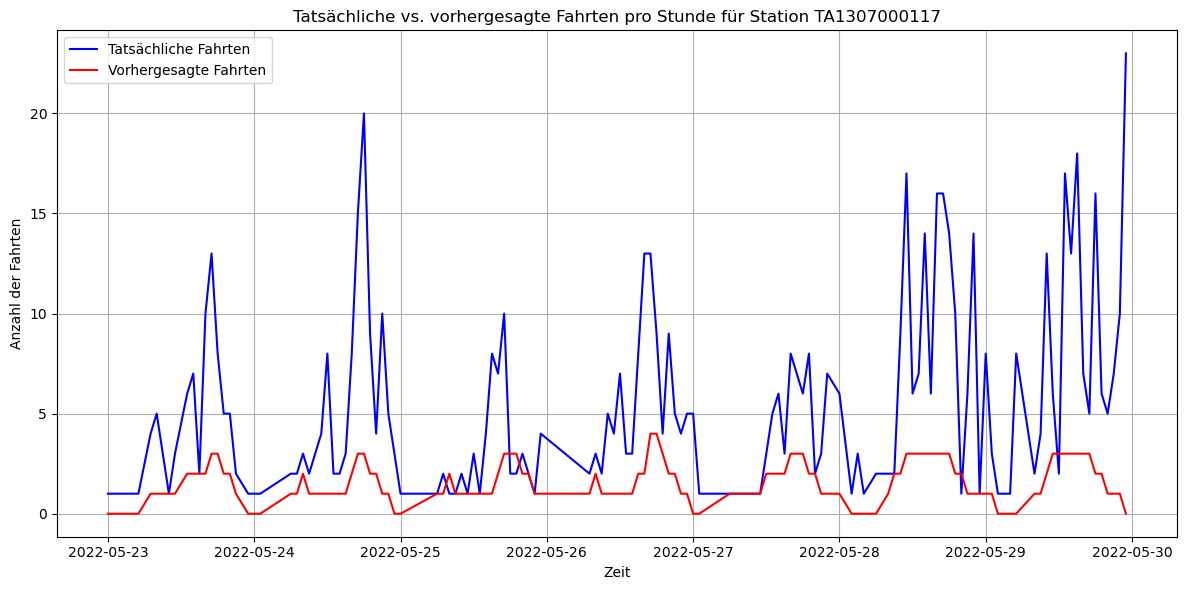

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


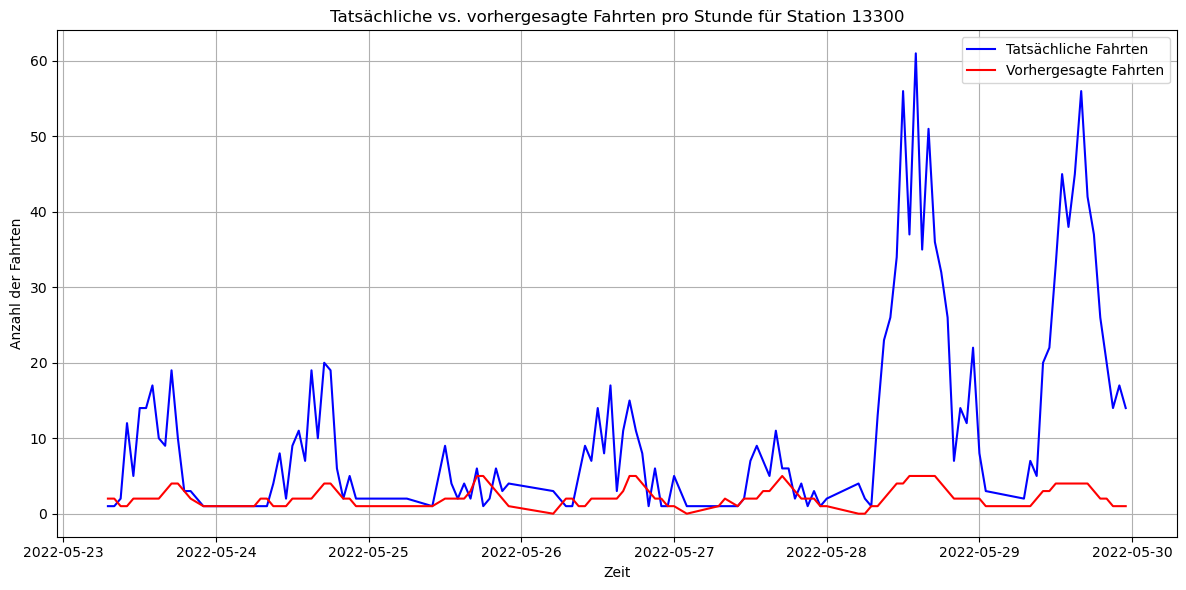

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


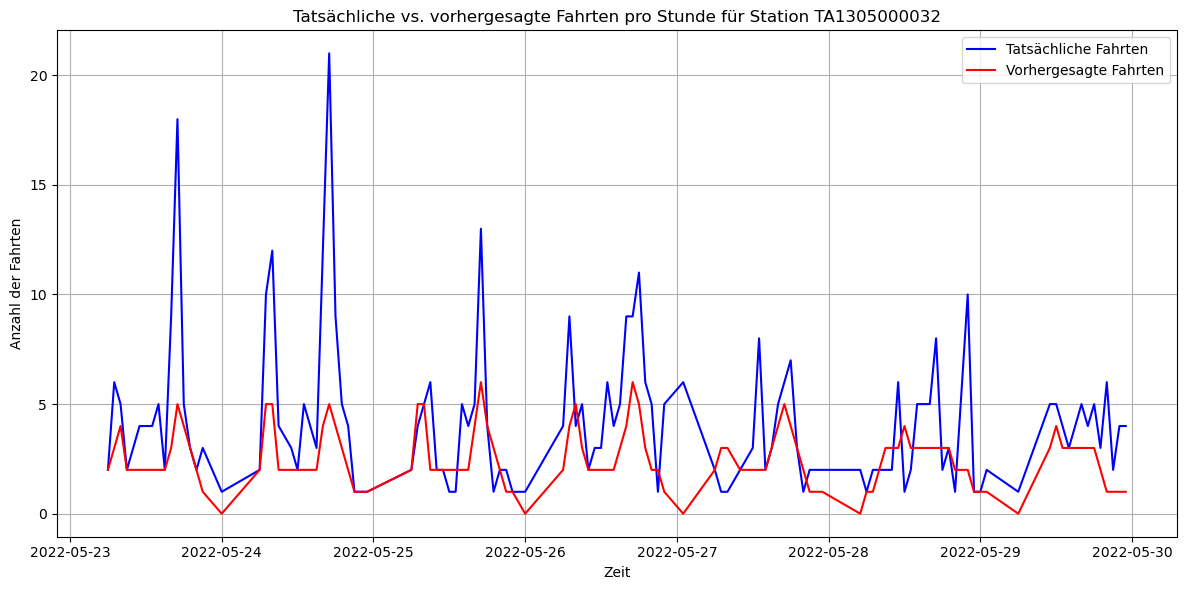

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


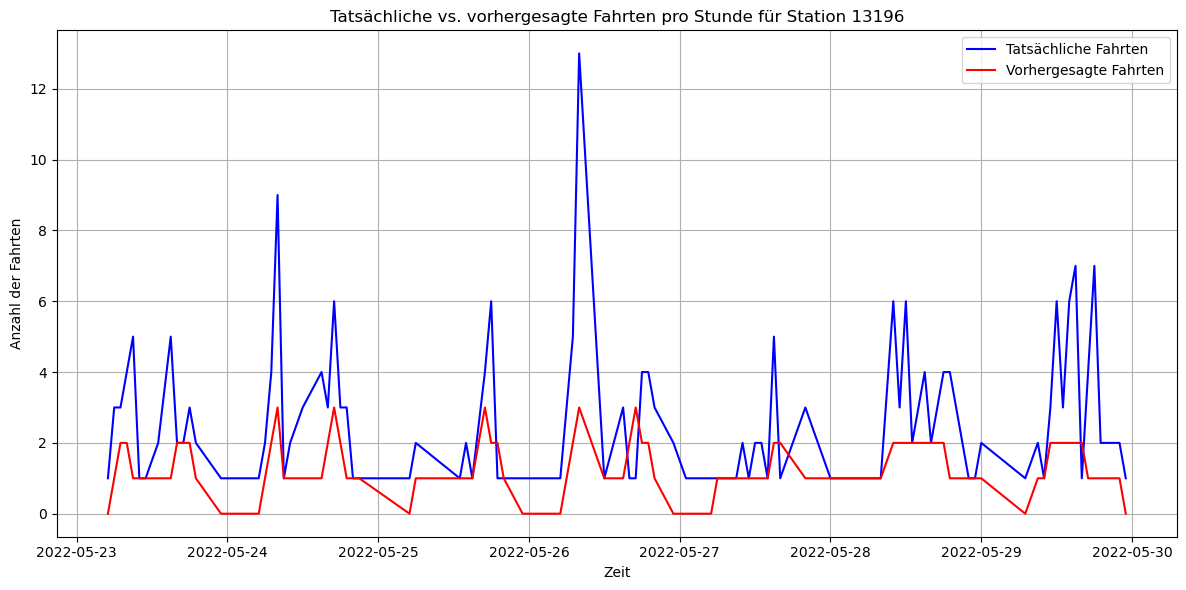

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


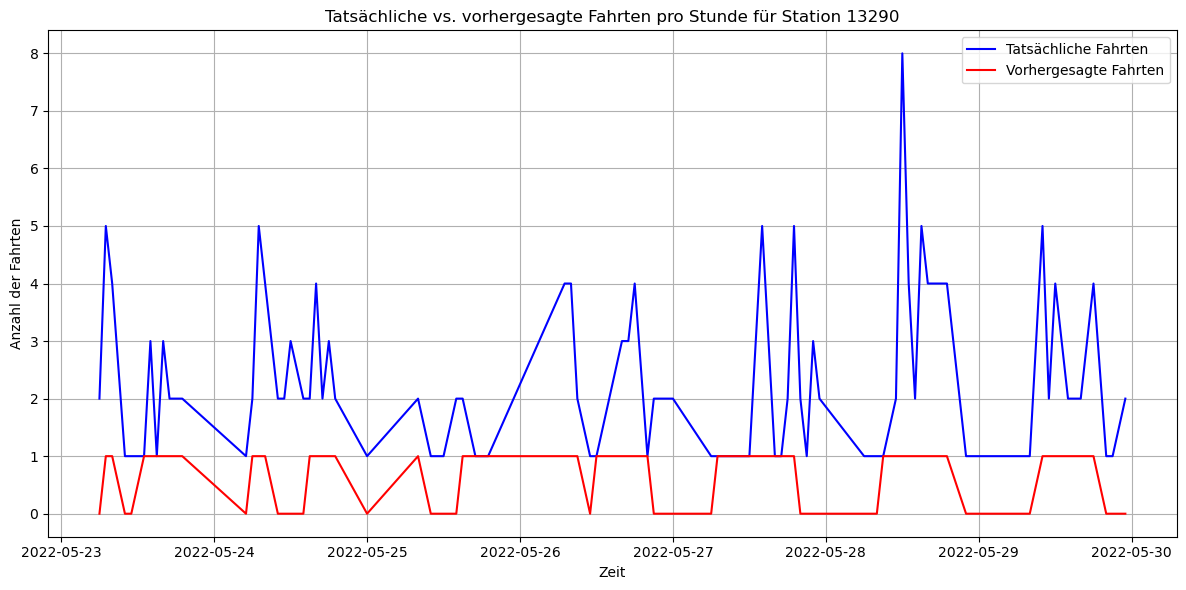

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


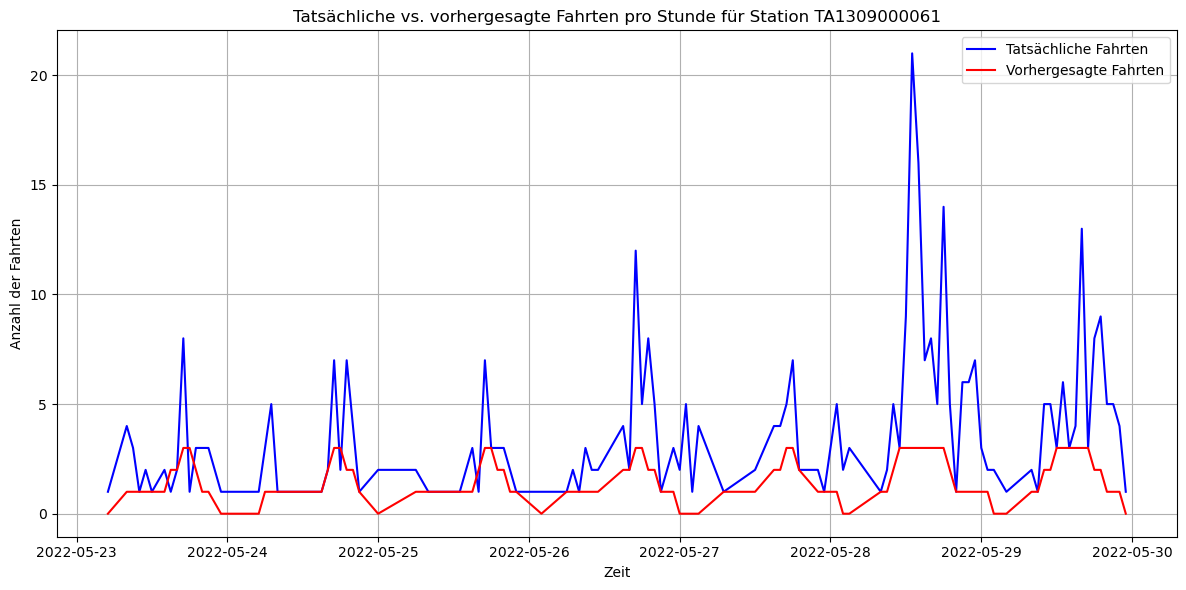

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


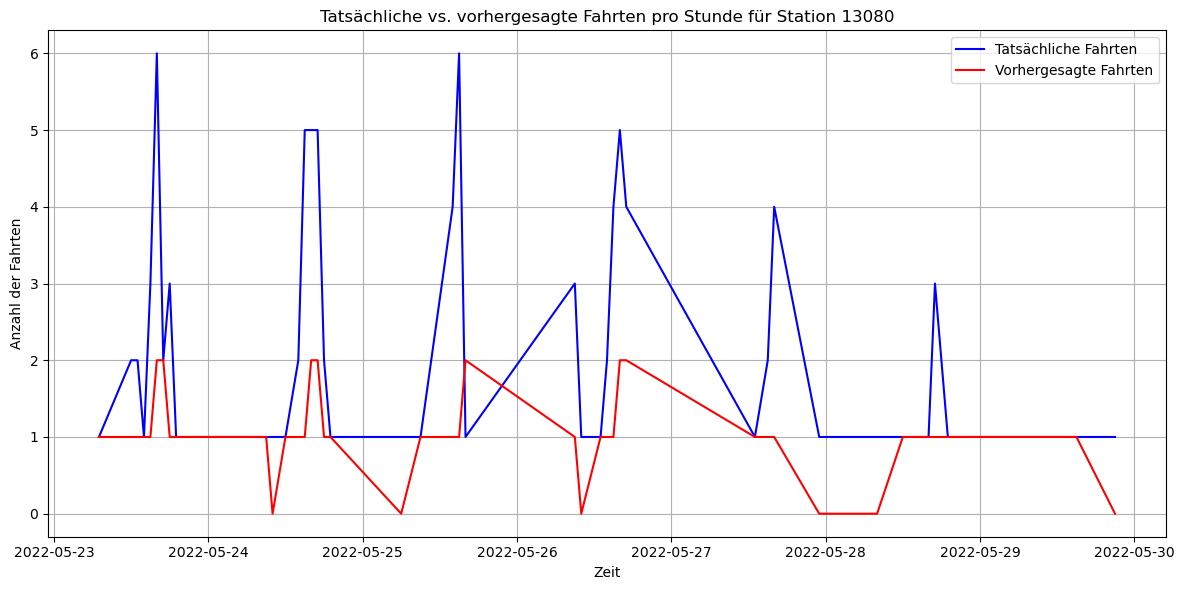

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


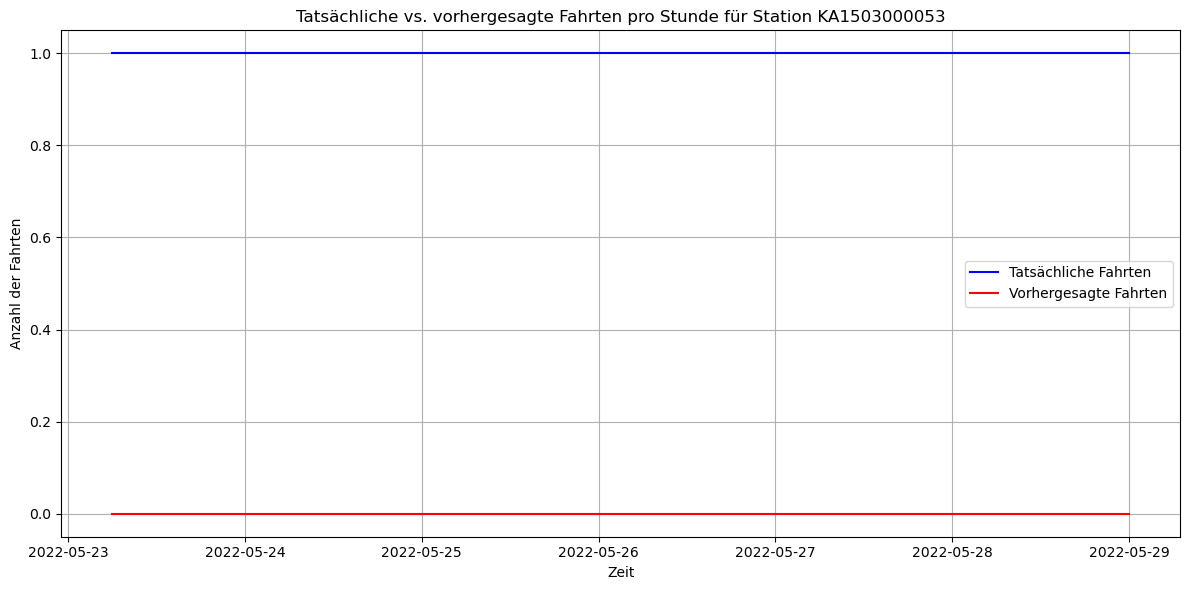

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


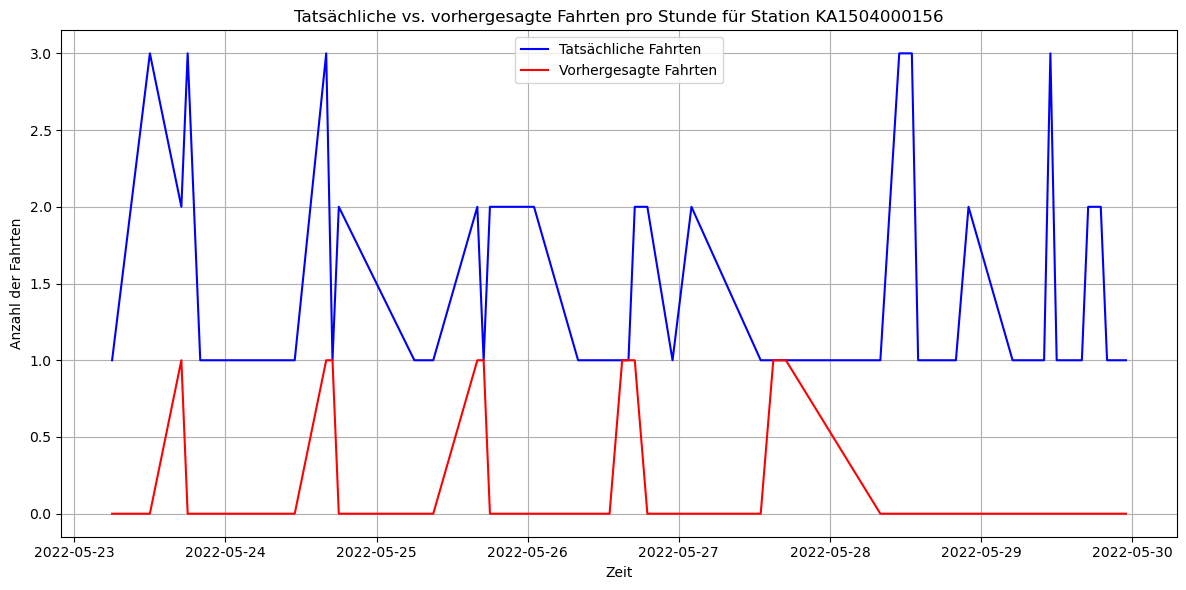

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


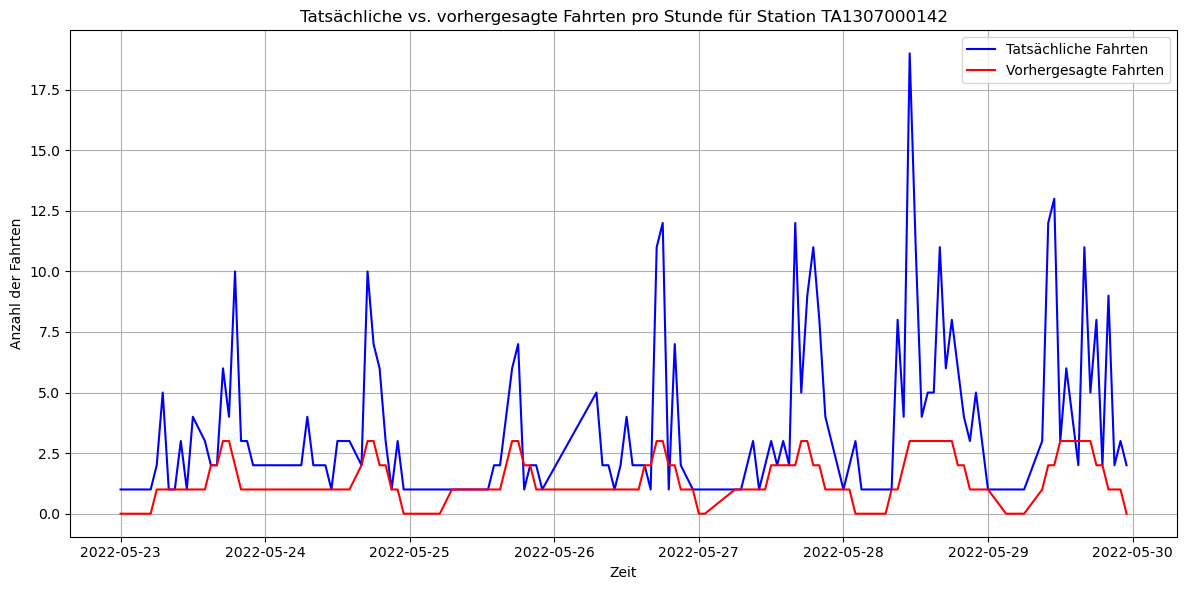

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


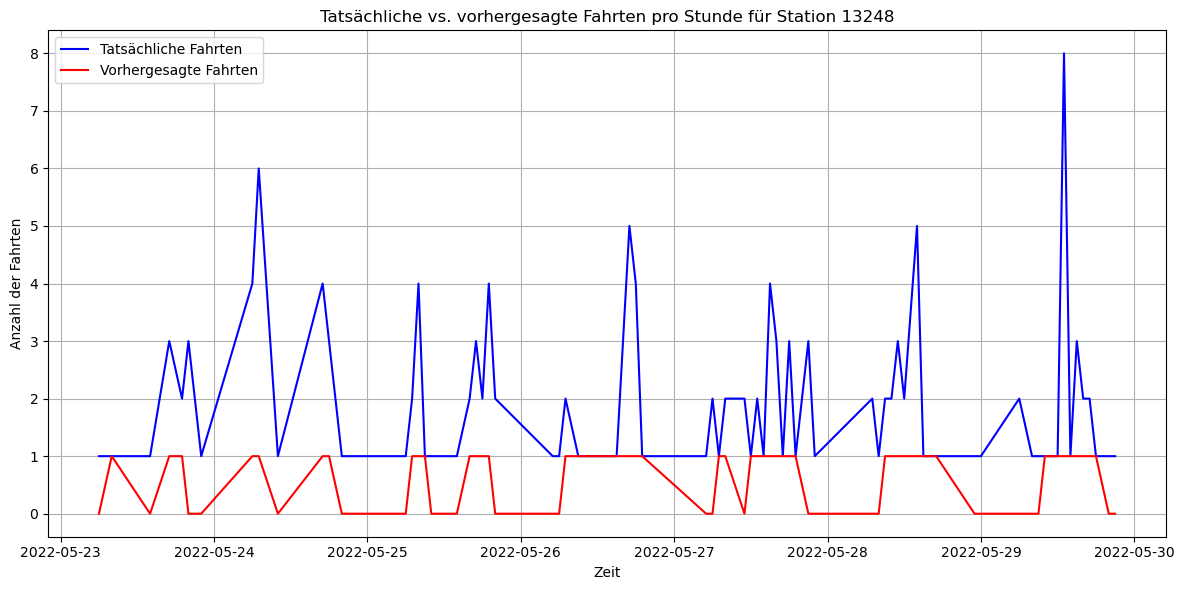

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


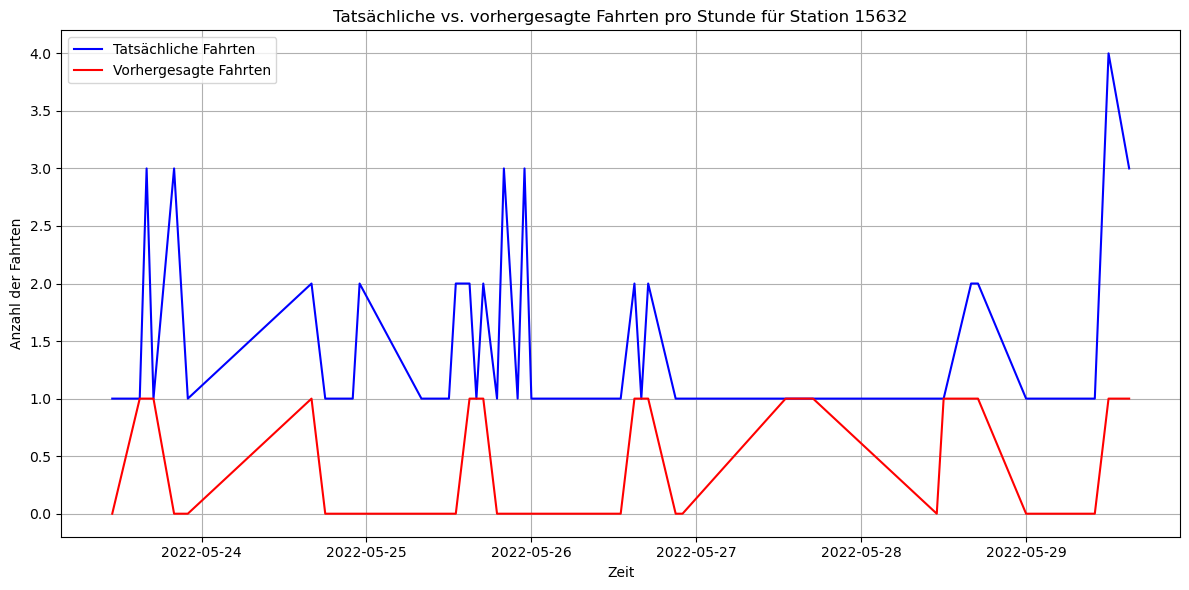

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


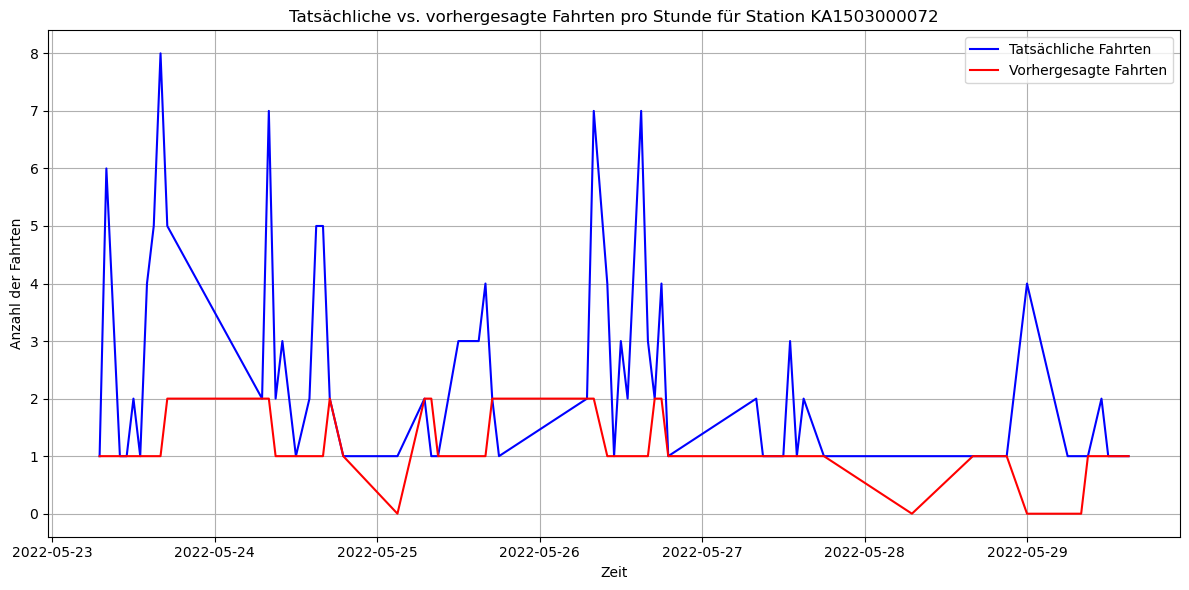

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


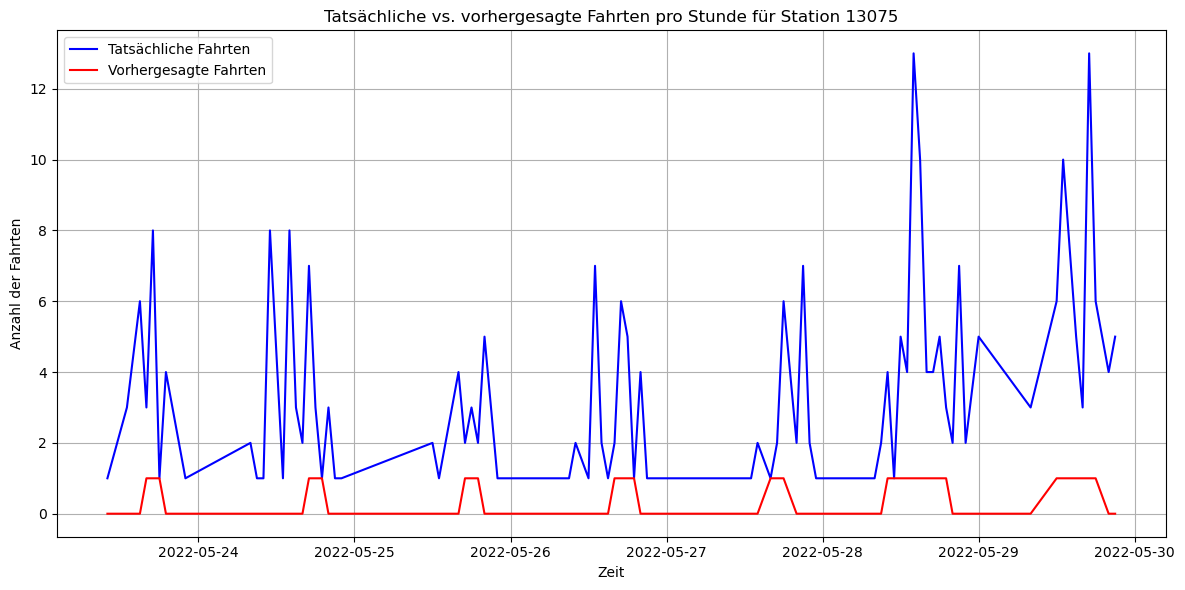

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


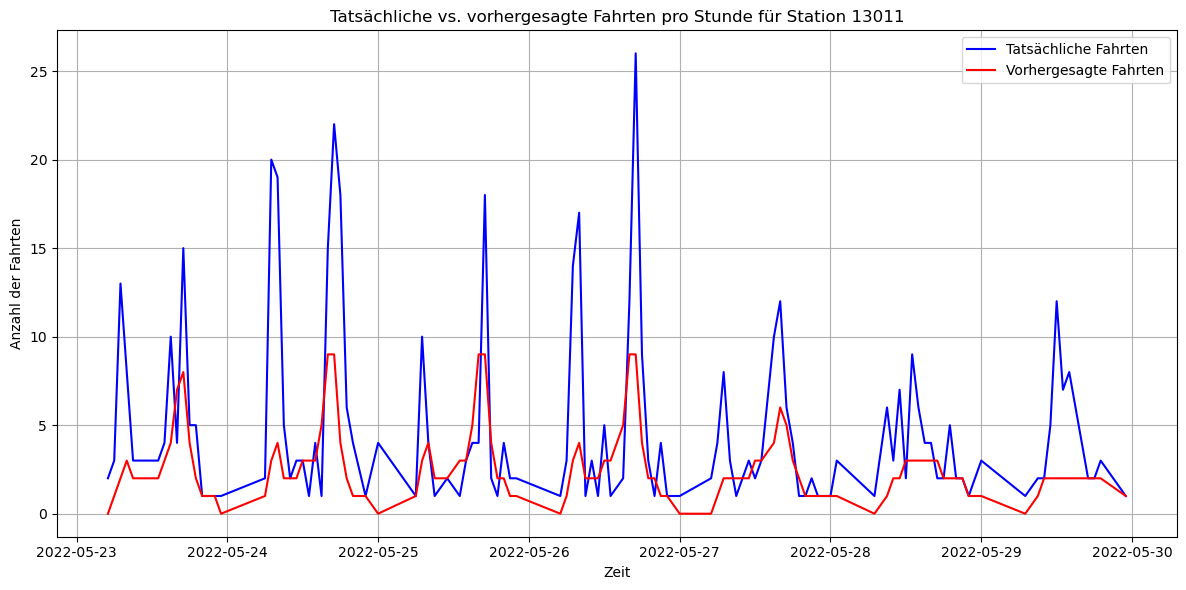

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


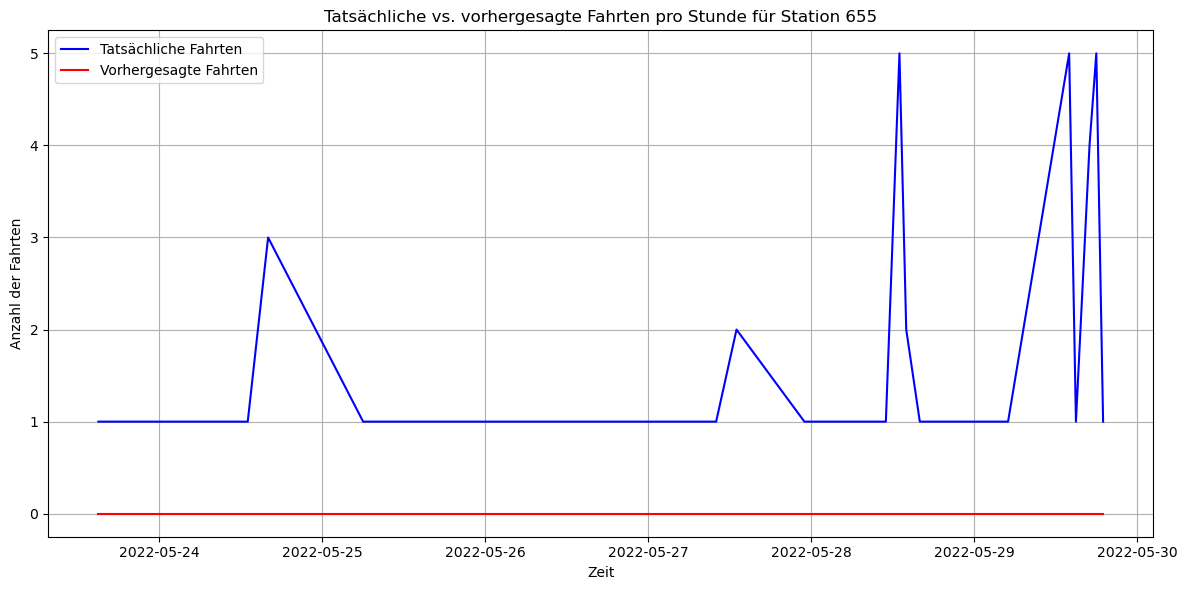

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


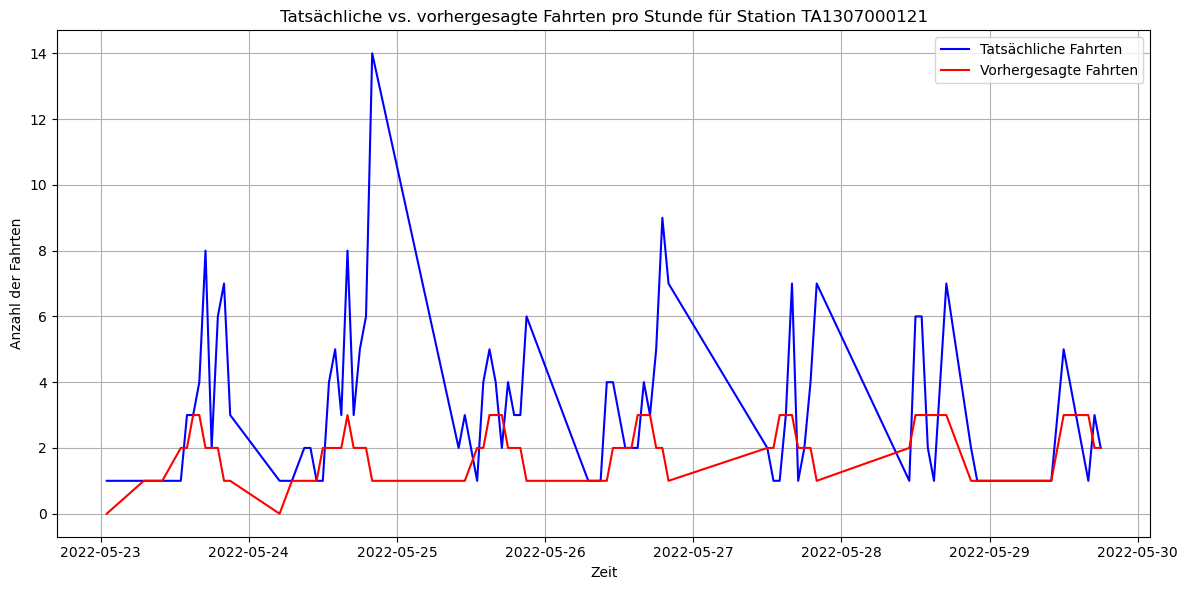

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


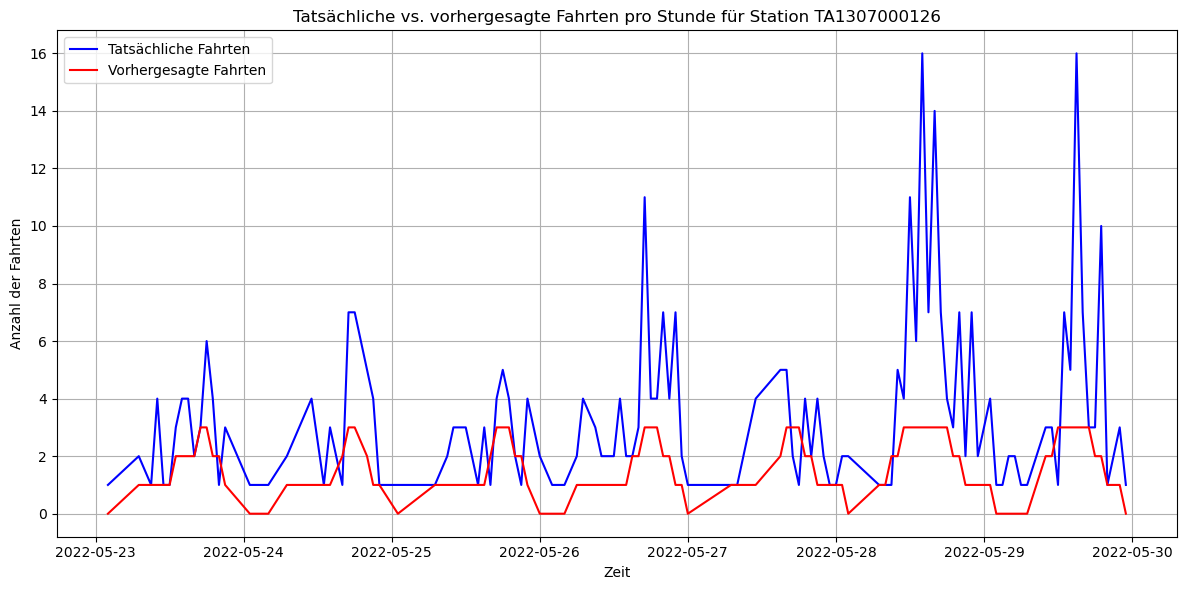

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


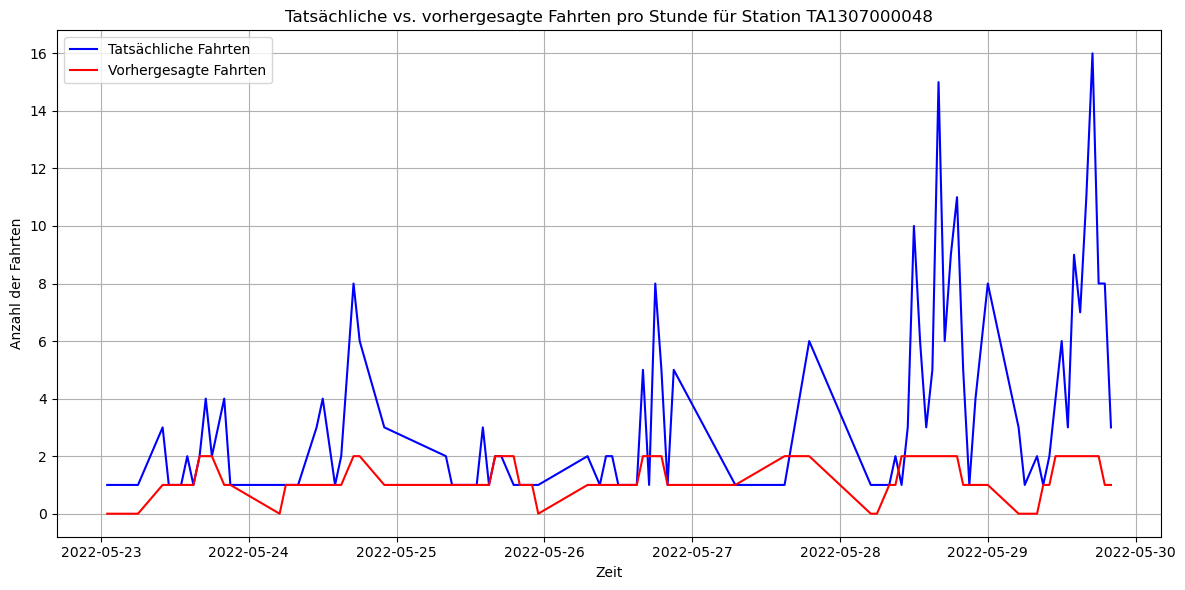

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_14939/860719563.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['hour'] = actual_data['started_at'].dt.floor('H')


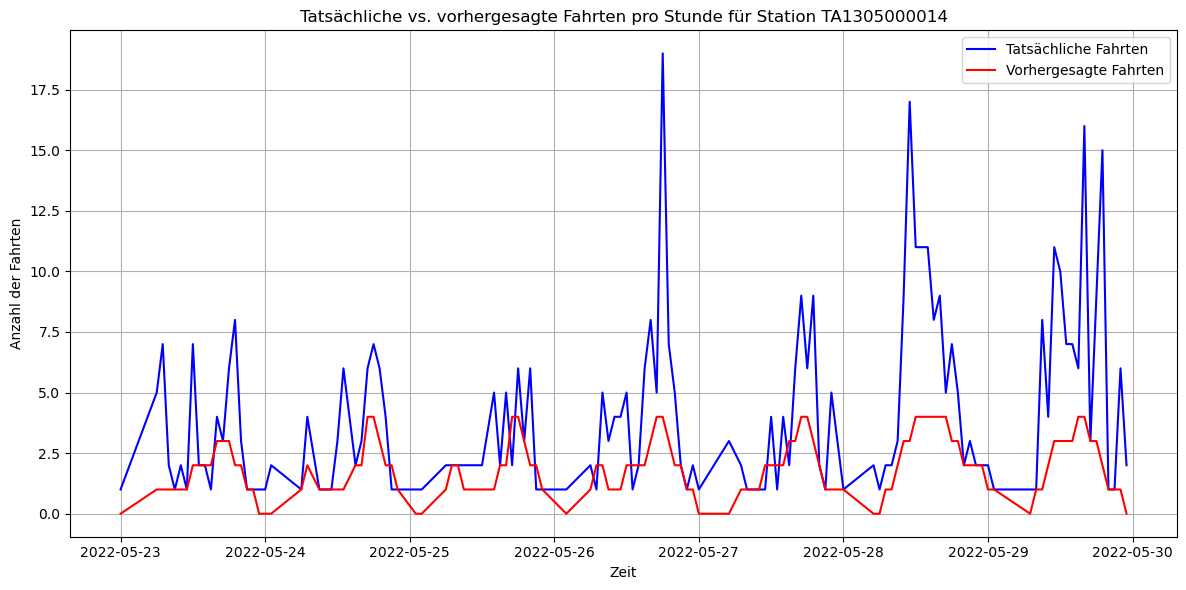

In [18]:
import matplotlib.pyplot as plt

# Wählen Sie die ersten 20 einzigartigen Stationen-IDs aus dem DataFrame aus
selected_station_ids = df['start_station_id'].unique()[:20]

for selected_station_id in selected_station_ids:
    actual_data = df[(df['start_station_id'] == selected_station_id) & 
                     (df['started_at'] >= '2022-05-23') & 
                     (df['started_at'] < '2022-05-30')]  # Passen Sie das Datum entsprechend an

    # Aggregieren der Daten nach Stunde
    actual_data['hour'] = actual_data['started_at'].dt.floor('H')
    actual_rides = actual_data.groupby('hour').size()

    # Tatsächliche Daten darstellen
    plt.figure(figsize=(12, 6))
    actual_time_index = actual_rides.index
    plt.plot(actual_time_index, actual_rides, label='Tatsächliche Fahrten', color='blue')

    # Vorhergesagte Daten vorbereiten
    predicted_data = detailed_forecasts.get(selected_station_id, {})
    forecast_values = [predicted_data.get((d.weekday(), d.hour), 0) for d in actual_time_index]

    # Vorhergesagte Fahrten darstellen
    plt.plot(actual_time_index, forecast_values, label='Vorhergesagte Fahrten', color='red')

    # Titel und Legende
    plt.title(f'Tatsächliche vs. vorhergesagte Fahrten pro Stunde für Station {selected_station_id}')
    plt.xlabel('Zeit')
    plt.ylabel('Anzahl der Fahrten')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Verbessert die Darstellung des Diagramms
    plt.show()


In [3]:
df = df.copy()
df['started_at'] = pd.to_datetime(df['started_at'])
df['hour'] = df['started_at'].dt.hour
df['weekday'] = df['started_at'].dt.dayofweek
df['weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)

demand_patterns = {}
for cluster_id in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster_id]
    hourly_counts = cluster_data.groupby(['weekday', 'hour']).size()
    total_rides = hourly_counts.sum()
    demand_pattern = hourly_counts / total_rides
    demand_patterns[cluster_id] = demand_pattern


In [4]:


# Berechnung des Demand Patterns und Erstellung des Forecasts für jede Station
station_forecasts = {}
for cluster_id in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster_id]
    station_ids = cluster_data['start_station_id'].unique()
    
    for station_id in station_ids:
        station_data = cluster_data[cluster_data['start_station_id'] == station_id]
        weekly_data = station_data.resample('W', on='started_at').count()['ride_id'].reset_index(name='count')
        
                # ARIMA-Modell für jede Station
        model = ARIMA(weekly_data['count'], order=(1, 0, 0))
        model_fit = model.fit()

            # Vorhersage für die nächste Woche
        forecast = model_fit.forecast(steps=1)

        # Zugreifen auf den ersten (und einzigen) Vorhersagewert
        forecast_value = forecast.iloc[0]



        # Anwendung des Demand Patterns des Clusters für die stündliche Vorhersage
        demand_pattern = demand_patterns[cluster_id]
        station_forecast = {}
        for (weekday, hour), proportion in demand_pattern.items():
            forecast_value = forecast * proportion  # Wochenprognose angepasst an stündliche Anteile
            station_forecast[(weekday, hour)] = round(forecast_value)

        station_forecasts[station_id] = station_forecast


In [14]:
from pmdarima import auto_arima

# Annahme: `weekly_data` ist der DataFrame mit Ihren Zeitreihendaten
model = auto_arima(weekly_data['count'], 
                   seasonal=False,  # Schalten Sie dies ein, wenn Sie eine saisonale Komponente erwarten
                   trace=True,  # Gibt den Auswahlprozess aus
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)  # Schrittweise Suche durchführen

# Drucken der Zusammenfassung des ausgewählten Modells
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=350.572, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=285.778, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=319.562, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=284.369, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=283.561, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=284.802, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=275.892, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=274.003, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=272.005, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=277.698, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=274.003, Time=0.01 se

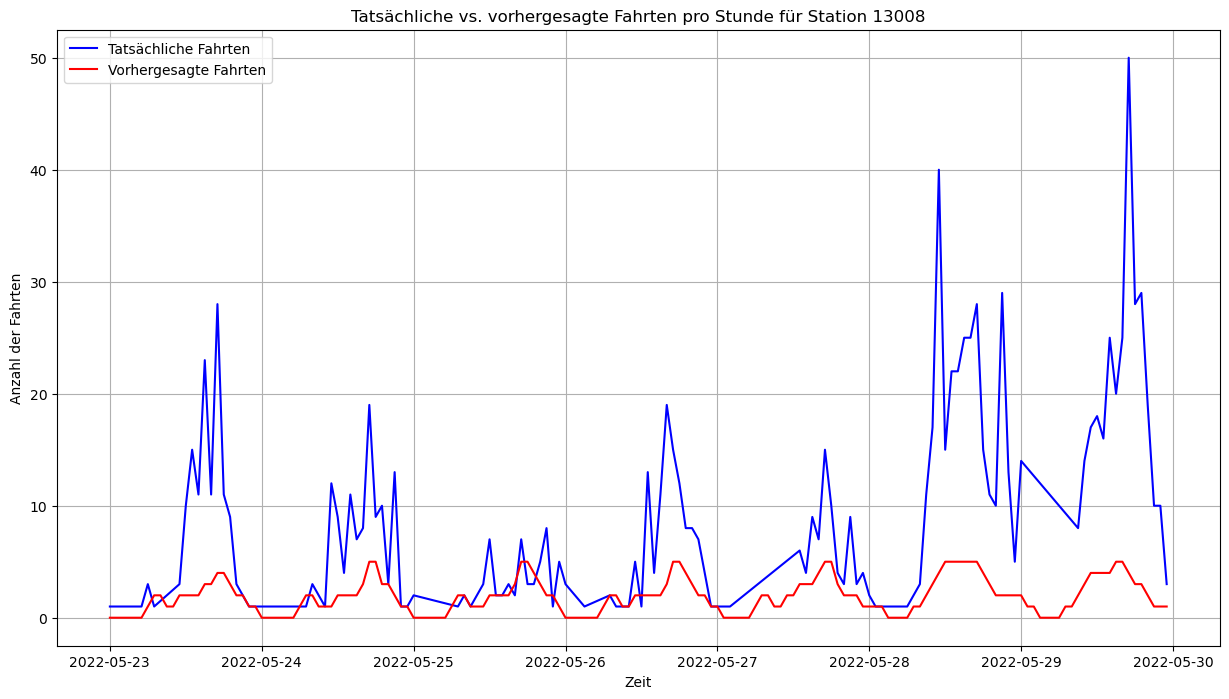

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Station auswählen
selected_station_id = '13008'

# Tatsächliche Daten für die Station und den Zeitraum extrahieren
actual_data = df[(df['start_station_id'] == selected_station_id) & 
                 (df['started_at'] >= '2022-05-23') & 
                 (df['started_at'] < '2022-05-30')]

# Aggregieren der tatsächlichen Daten nach Stunde
actual_rides = actual_data.groupby(actual_data['started_at'].dt.floor('H')).size()

# Vorhersagedaten für die Station extrahieren
forecast_data = station_forecasts[selected_station_id]

# Erstellen eines DataFrame aus den vorhergesagten Werten, angepasst an den Zeitindex
forecast_df = pd.DataFrame({
    'datetime': pd.date_range('2022-05-23', periods=len(forecast_data), freq='H'),
    'forecast': list(forecast_data.values())
})

# Erstellen des Plots
plt.figure(figsize=(15, 8))
plt.plot(actual_rides.index, actual_rides, label='Tatsächliche Fahrten', color='blue')
plt.plot(forecast_df['datetime'], forecast_df['forecast'], label='Vorhergesagte Fahrten', color='red')

plt.title(f'Tatsächliche vs. vorhergesagte Fahrten pro Stunde für Station {selected_station_id}')
plt.xlabel('Zeit')
plt.ylabel('Anzahl der Fahrten')
plt.legend()
plt.grid(True)
plt.show()
